#### **Joke Evaluator With Human Feedback**

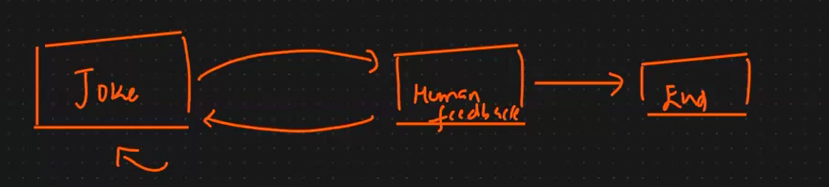

In [34]:
# Importing the necessary packages
import os
from dotenv import load_dotenv
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import SystemMessage, HumanMessage
from langchain.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field
from typing_extensions import TypedDict
from langgraph.types import interrupt, Command
from langgraph.checkpoint.memory import MemorySaver
from langchain_groq import ChatGroq
from typing_extensions import Literal
load_dotenv()

True

In [35]:
# Loading the environment variables
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

In [36]:
# Load the LLM
llm = ChatGroq(model="qwen-2.5-32b",temperature=0.3)
llm.invoke("Hi! I am Hrishikesh")

AIMessage(content="Hello Hrishikesh! It's nice to meet you. How can I assist you today? Is there anything specific you're interested in or need help with?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 34, 'prompt_tokens': 37, 'total_tokens': 71, 'completion_time': 0.17, 'prompt_time': 0.004374675, 'queue_time': 0.22241945000000002, 'total_time': 0.174374675}, 'model_name': 'qwen-2.5-32b', 'system_fingerprint': 'fp_35f92f8282', 'finish_reason': 'stop', 'logprobs': None}, id='run-05912e3e-6cc5-47ff-a2a7-f7d382a78c8d-0', usage_metadata={'input_tokens': 37, 'output_tokens': 34, 'total_tokens': 71})

In [17]:
# Define the state
class State(TypedDict):
    joke: str
    topic: str
    llm_feedback: str
    human_feedback: str
    llm_grade: str
    human_grade:str
    
    
class FeedbackModel(BaseModel):
    grade: Literal["funny", "not funny"] = Field(
        description="Decide if the joke is funny or not.",
    )
    feedback: str = Field(
        description="If the joke is not funny, provide feedback on how to improve it.",
    )

LLMEvaluator = llm.with_structured_output(FeedbackModel)    
    
    
class HumanFeedbackModel(BaseModel):
    grade: Literal["funny","not funny"] = Field(
        description="Decide if the joke is funny or not."
    )
HumanFeedbackEvaluator = llm.with_structured_output(HumanFeedbackModel)

In [18]:
# prompts

joke_generation_prompt = """
You are a comedy content writer, your task is to generate the joke. follow the below instructions while generating the joke

1. Generate the joke on topic : {topic}
        
2. Examine any human feedback that has been provided to guide creation of the joke : {human_feedback}
                       
3. Examine any llm feedback that has been provided to guide creatio of the joke : {llm_feedback}       
"""

joke_evaluator_prompt = """ You are a comedy content writer and reader, you task is to evaluate the given joke {joke}. follow the below instruction while evaluating the joke
1. Grade the joke as 'funny' or 'not funny'.

2. Also provide the feedback for the improvement in the joke.
"""

human_evaluator_prompt = """ You are a content grader, your task is to analyse the feedback given by human to the generated joke and then analyses whether the user like the joke or not into three grades 'funny' or 'not funny'.
The human feedback : {human_feedback}"""

In [ ]:
# Define the Node functions

def joke_generator(state:State):
    """LLM generates the joke"""
    topic = state["topic"]
    human_feedback = state.get('human_feedback','')
    llm_feedback = state.get('llm_feedback','')
    
    # System Message
    system_message = joke_generation_prompt.format(topic=topic,human_feedback=human_feedback,llm_feedback=llm_feedback)
    
    # Generate the joke 
    joke = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content="Write the message about the given topic")])
    
    return {"joke":joke.content} 


def llm_joke_evaluator(state:State):
    """LLM evaluates the generated joke"""
    joke = state["joke"]
    
    # System Message
    system_message = joke_evaluator_prompt.format(joke=joke)
    
    # evaluate the joke
    joke_evaluation = LLMEvaluator.invoke([SystemMessage(content=system_message)]+[HumanMessage(content="Evaluate the generated joke.")]) 
    llm_feedback = joke_evaluation.feedback
    llm_grade = joke_evaluation.grade
    
    return {"llm_feedback":llm_feedback,"llm_grade":llm_grade}


def human_joke_evaluator(state:State):
    "Human evaluated the generated joke"
    # human_feedback = interrupt("Hey! Do you feel it funny or not ?")
    # state["human_feedback"] = human_feedback
    
    # System Message
    system_message = human_evaluator_prompt.format(human_feedback=state["human_feedback"])
    
    # grade the human feedback
    human_feedback_evaluator = HumanFeedbackEvaluator.invoke([SystemMessage(content=system_message)]+[HumanMessage(content="Evaluate the human feedback")])
    
    # Grade the human feeback
    human_grade = human_feedback_evaluator.grade
    
    return {"human_feedback": state["human_feedback"],"human_grade":human_grade}

def router(state:State):
    """Route back to joke generator or end based upon feedback from the evaluator"""
    
    if state["llm_grade"] == "funny" and state["human_grade"] == "funny":
        return "Accepted"
    elif state["llm_grade"] == "not funny" and state["human_grade"] == "not funny":
        return "Rejected + Feedback"
    elif state["llm_grade"] == "funny" and state["human_grade"] == "not funny":
        return "Rejected + Feedback"
    elif state["llm_grade"] == "not funny" and state["human_grade"] == "funny":
        return "Accepted"
    elif state["llm_grade"] == "funny" and state["human_grade"] == "neutral":
        return "Accepted"
    elif state["llm_grade"] == "not funny" and state["human_grade"] == "neutral":
        return "Rejected + Feedback"

In [38]:
# Build workflow
optimizer_builder = StateGraph(State)

# Add the nodes
optimizer_builder.add_node("joke_generator", joke_generator)
optimizer_builder.add_node("llm_joke_evaluator", llm_joke_evaluator)
optimizer_builder.add_node("human_joke_evaluator", human_joke_evaluator)

# Add edges to connect nodes
optimizer_builder.add_edge(START, "joke_generator")
optimizer_builder.add_edge("joke_generator", "llm_joke_evaluator")
optimizer_builder.add_edge("llm_joke_evaluator", "human_joke_evaluator")

optimizer_builder.add_conditional_edges(
    "human_joke_evaluator",
    router,
    {  # Name returned by route_joke : Name of next node to visit
        "Accepted": END,
        "Rejected + Feedback": "joke_generator",
    },
)

# Compile the workflow
memory = MemorySaver()
optimizer_workflow = optimizer_builder.compile(checkpointer=memory,interrupt_before=["human_joke_evaluator"])

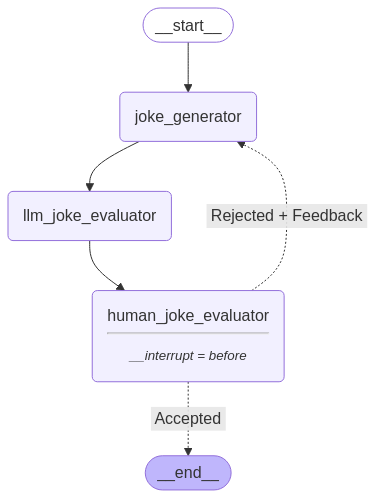

In [39]:
optimizer_workflow

In [40]:
# Define the config
from datetime import datetime
config  = {"configurable":{"thread_id": datetime.now().strftime("%Y%m%d%H%M%S%f")}}

In [41]:
optimizer_workflow.invoke(input={"topic":"Cricket"},config=config)

{'joke': "Sure, here's a cricket-themed joke for you:\n\nWhy did the cricket player bring a ladder to the match?\n\nBecause he wanted to reach for the stars, but he settled for a six!",
 'topic': 'Cricket',
 'llm_feedback': "The joke plays on the dual meaning of 'reach for the stars' and 'settling for a six', which is a cricket term for hitting the ball out of the park. However, it could be improved by making the setup more intriguing or by adding a twist to the punchline.",
 'llm_grade': 'funny'}

In [42]:
# response = optimizer_workflow.invoke(
#         {"topic": "Programmer"},
#         config=config, 
#         stream_mode="values"
#     )

In [43]:
# response

In [44]:
# The workflow is now trying to call the human joke evaluator for human feedback.
snapshot = optimizer_workflow.get_state(config)
snapshot.next

('human_joke_evaluator',)

In [46]:
# Flow asking us to give the feedback
# snapshot.tasks[0].interrupts[0].value

In [47]:
# provide the feedback to the flow
# response = optimizer_workflow.invoke(Command(resume="Make it more funnier"),config=config,stream_mode="values")
# response

In [48]:
# snapshot = optimizer_workflow.get_state(config)
# snapshot.next

In [49]:
# for event in optimizer_workflow.stream(
#     Command(resume="Make it more funnier"), config, stream_mode="updates"
# ):
#     print(event)
#     print("\n")

In [50]:
# for event in optimizer_workflow.stream(
#     Command(resume="The joke is funny"), config, stream_mode="updates"
# ):
#     print(event)
#     print("\n")

In [52]:
optimizer_workflow.update_state(config=config, values={"human_feedback": "Make it more funnier"})

{'configurable': {'thread_id': '20250303201531736191',
  'checkpoint_ns': '',
  'checkpoint_id': '1eff83f0-840e-654c-8003-1ffd1877505b'}}

In [53]:
for event in optimizer_workflow.stream(None, config, stream_mode="values"):
    # Review
    print(event)
    print("\n")

{'joke': "Sure, here's a cricket-themed joke for you:\n\nWhy did the cricket player bring a ladder to the match?\n\nBecause he wanted to reach for the stars, but he settled for a six!", 'topic': 'Cricket', 'llm_feedback': "The joke plays on the dual meaning of 'reach for the stars' and 'settling for a six', which is a cricket term for hitting the ball out of the park. However, it could be improved by making the setup more intriguing or by adding a twist to the punchline.", 'human_feedback': 'Make it more funnier', 'llm_grade': 'funny'}


{'joke': "Sure, here's a cricket-themed joke for you:\n\nWhy did the cricket player bring a ladder to the match?\n\nBecause he wanted to reach for the stars, but he settled for a six!", 'topic': 'Cricket', 'llm_feedback': "The joke plays on the dual meaning of 'reach for the stars' and 'settling for a six', which is a cricket term for hitting the ball out of the park. However, it could be improved by making the setup more intriguing or by adding a twis

In [54]:
optimizer_workflow.update_state(config=config, values={"human_feedback": "It is funny"})

{'configurable': {'thread_id': '20250303201531736191',
  'checkpoint_ns': '',
  'checkpoint_id': '1eff83f3-1015-67ff-8007-4b8376640b92'}}

In [55]:
for event in optimizer_workflow.stream(None, config, stream_mode="updates"):
    # Review
    print(event)
    print("\n")

{'human_joke_evaluator': {'human_feedback': 'It is funny', 'human_grade': 'funny'}}


